# **Generative Adversarial Networks(GANs)**
<img align='right' width='800' src="https://cdn-images-1.medium.com/v2/resize:fit:851/0*pPEL7ryJR51VpnDO.jpg">

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os

import scipy

import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms

In [2]:
# Hyperparameters
EPOCH = 20
Z_DIM = 100
LR = 2e-4
BS = 64
C, H, W = 1, 32, 32
NUM_CLASS = 10 # 0, 1, 2, ..., 9
EMBED_SIZE = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Availabe device is: ", device)

Availabe device is:  cuda


## **Fréchet inception distance (FID)**
Fréchet inception distance (FID) is a metric for quantifying the realism and diversity of images generated by generative adversarial networks (GANs). Realistic could mean that generated images of people look like real images of people. Diverse means they are different enough from the original to be interesting and novel.It's a metric that calculates the distance between **feature vectors** calculated for real and generated images Not image itself.

FID was proposed as an improvement over the existing **Inception Score**.

<br>

<img align='right' width='400' src="https://omrit.filtser.com/lib/man-dog2.gif">

The Fréchet distance quantifies the similarity of two curves. First introduced in 1906 by Maurice Fréchet, it quantifies the minimum length of leash required between a dog and walker while each walked a separate curved path of a certain distance.

The **Inception-v3** model used in FID is one in a library of modules introduced by Google as part of its GoogLeNet convolutional neural network in 2014. It was first discussed in a [research paper](https://arxiv.org/pdf/1409.4842.pdf). These various inception models are sometimes used to extract features in computer vision tasks and detect objects. Despite not being the latest model, the Inception-v3 model combined with the Fréchet distance is best suited for analyzing GAN imagery.

FID is measured by computing the differences between the representations of **features**, such as edges and lines, and higher-order phenomena, such as the shapes of eyes or how manu eyes ,nose, ears, legs, ... the images have that are transformed into an intermediate latent space. FID is calculated using the following steps:


1. **Extract feature representations:** Pass the real and generated images through the Inception-v3 model. This transforms the raw pixels into numerical vectors to represent aspects of the images, such as lines, edges and higher-order shapes.
2. **Calculate statistics:** Statistical analysis is performed to determine the mean and covariance matrix of the features in each image.
3. **Compute the Fréchet distance:** Compare the difference between each image's computed mean and covariance matrixes.
4. **Obtain the FID:** Compare the Fréchet distance between the real and generated images. Lower numbers indicated the images are more similar.

- Although keep in mind as always the input images must be Preprocessed to statisfy the Inception-v3 model requirment. This can include resizing to a given dimension size (-, 3, 299, 299), and then normalizing pixel values.


You can have access to orginal paper [here](https://arxiv.org/abs/1706.08500017)


##**How to Calculate the Frechet Inception Distance:**

First loading a pre-trained Inception v3 model.
The output layer of the model is removed and the output is taken as the activations from the last pooling layer, **Mixed_7c layer**
<img align='right' width='500' src="https://pytorch.org/assets/images/googlenet1.png">
- Mixed layer in inception model typically consist of a set of parallel convolutional branches with different filter sizes and are designed to capture features at multiple scales

This output layer has 2,048 activations, therefore, each image is predicted as 2,048 activation features. This is called the coding vector or feature vector for the image.The result will be two collections of 2,048 feature vectors for real and generated images.

For two **multidimensional Gaussian distributions** ${\displaystyle {\mathcal {N}}(\mu ,\Sigma )} $ and ${\displaystyle {\mathcal {N}}(\mu',\Sigma ')}$, **Fréchet distance** is explicitly solvable as:

<br>

$$
    \large d_F\left({\displaystyle {\mathcal {N}}(\mu ,\Sigma )},{\mathcal {N}}(\mu',\Sigma ') \right)^2 = {\displaystyle \|\mu_1 - \mu_2 \|^2} + Tr \left( {\displaystyle \Sigma + \Sigma^{'} - 2 \sqrt{\Sigma \Sigma^{'}}} \right) + \log{\left(\frac{\text{det}(\Sigma \Sigma^{'})}{\sqrt{\text{det}(\Sigma)\cdot \text{det}(\Sigma^{'})}} \right)}
$$

<br>
<br>

- The score is referred to as $\large d_F\left({\displaystyle {\mathcal {N}}(\mu ,\Sigma )}, {\mathcal {N}}(\mu',\Sigma ') \right)^2$, showing that it is a distance and has squared units.

- The $\large \mu_1 \mu_2 $ refer to the feature-wise **mean** of the real and generated images, e.g. 2,048 element vectors where each element is the mean feature observed across the images.

- The $\large \Sigma, \Sigma^{'}$ are the **covariance matrix** for the real and generated feature vectors, often referred to as sigma.

- The $\large {\displaystyle \|\mu_1 - \mu_2 \|^2}$ ( denotes the Euclidean norm.) refers to the sum squared difference between the two mean vectors. $\large Tr$ refers to the trace linear algebra operation, e.g. the sum of the elements along the main diagonal of the square matrix.

- The $\large \sqrt{\Sigma \Sigma^{'}}$ is the square root of the square matrix, given as the product between the two covariance matrices. not element wise square root. This operation can fail depending on the values in the matrix because the operation is solved using numerical methods. Commonly, some elements in the resulting matrix may be imaginary, which often can be detected and removed.
- $\large det(⋅)$ denotes the determinant of a matrix.

<br>

### **The logarithmic term in the Fréchet Distance formula:**

involving determinants $\large \log{\left(\frac{\text{det}(\Sigma \Sigma^{'})}{\sqrt{\text{det}(\Sigma)\cdot \text{det}(\Sigma^{'})}} \right)}$ is related to the volume of the covariance matrices and plays a crucial role in capturing the differences in the shapes of the distributions.

**In summary**, the logarithmic term helps to quantify how the covariance ellipsoids of the two distributions differ in terms of volume and orientation. Including this term enhances the sensitivity of the Fréchet Distance to variations in the shapes of the distributions, providing a more comprehensive measure of their dissimilarity.Here's a brief explanation of how this term contributes:
1. **Determinants:**
    - $det(Σ)$ and $det(Σ^{'})$ represent the volumes (or "sizes") of the covariance ellipsoids for the two distributions.
    - $det(ΣΣ^{'})$ represents the volume of the product of the covariance ellipsoids.
2. **Logarithmic Term**

    - The logarithmic term essentially compares the ratio of the volume of the joint covariance ellipsoid $(ΣΣ^{'})$to the geometric mean of the individual covariance ellipsoids $\sqrt{det(Σ) \cdot det(Σ^{'}})$.
    - A positive value of this term indicates that the joint covariance ellipsoid has a larger volume than expected based on the individual distributions. A negative value indicates the opposite
3. **Significance:**

    - If the distributions have different shapes or orientations, the logarithmic term helps capture the non-sphericity or anisotropy in the joint distribution.
    - It penalizes cases where the two distributions have very different shapes, even if their means are close.

Below is a code block that calculates the Fréchet Distance between two sets of points using their neural network outputs. The mathematical formula is provided in LaTeX for clarity.

**Note:**The expression ```torch.linalg.solve(diff, sigma1)```.solution involves solving a linear system of equations using the torch.solve function in PyTorch.

In [156]:
import torch
from scipy.linalg import sqrtm
import numpy as np

def torch_cov(m, rowvar=False):
    """
    Estimate the covariance matrix of a matrix.

    Args:
        m (torch.Tensor): Input matrix which is output of the neural network
        rowvar (bool, optional): If True, then each row represents a variable, and each column a single observation.
                                 Default is False.

    Returns:
        torch.Tensor: Covariance matrix.
    """
    if not rowvar and m.shape[0] != 1:
        m = m.t()

    # Calculate mean along columns
    mean = torch.mean(m, dim=1, keepdim=True)

    # Center the data
    m_centered = m - mean

    # Calculate covariance matrix
    cov_matrix = torch.mm(m_centered, m_centered.t()) / (m.shape[1] - 1)

    return cov_matrix


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, logterm=False):
    """
    Calculate Fréchet Distance between two multivariate Gaussian distributions.

    Args:
        mu1 (torch.Tensor): Mean of the first distribution.
        sigma1 (torch.Tensor): Covariance matrix of the first distribution.
        mu2 (torch.Tensor): Mean of the second distribution.
        sigma2 (torch.Tensor): Covariance matrix of the second distribution.

    Returns:
        float: Fréchet Distance between the distributions.
    """
    from scipy.linalg import sqrtm

    # Compute the squared Mahalanobis distance between the means
    diff = mu1 - mu2
    diff_squared = torch.matmul(diff, diff)

    # Compute the product of square roots of covariance matrices
    cov_prod_sqrtm = sqrtm(sigma1 @ sigma2).real

    if not logterm:
        return diff_squared.item() + torch.trace(sigma1 + sigma2 - 2 * cov_prod_sqrtm.item())
    else:
        # Compute the logarithm of the product
        epsilon = 1e-6
        cov_prod = sigma1 @ sigma2 + epsilon * torch.eye(sigma1.shape[0])

        simga1_det = torch.det(sigma1 + epsilon * torch.eye(sigma1.shape[0]))
        simga2_det = torch.det(sigma2 + epsilon * torch.eye(sigma2.shape[0]))
        log_sqrtm = torch.sqrt(simga1_det * simga2_det)

        log_cov_prod = torch.log(torch.det(cov_prod) / log_sqrtm)

        # Return the Fréchet Distance
        return diff_squared.item() + torch.trace(sigma1 + sigma2 - 2 * cov_prod_sqrtm.item()) + log_cov_prod.item()


# -----------------------Example usage-------------------------
# Assuming net_output1 and net_output2 are the output tensors of two neural networks
# with shape (batch_size, feature_dim)

# Calculate mean and covariance for each set of two dummy point
net_output1, net_output2 = torch.randn(2048, 1), torch.randn(2048, 1)

mu1, sigma1 = torch.mean(net_output1, dim=0).view(-1, 1), torch_cov(net_output1, rowvar=False)
mu2, sigma2 = torch.mean(net_output2, dim=0).view(-1, 1), torch_cov(net_output2, rowvar=False)

# Calculate Fréchet Distance
frechet_distance = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
print(f"Fréchet Distance: {frechet_distance}")

Fréchet Distance: 0.0039103273302316666


## **Intermediate Activations — the forward hook in Pytorch**
In PyTorch, a forward hook is a function that is registered to be called when the forward pass of a neural network module is executed. It allows you to intercept and perform additional operations during the forward pass without modifying the original forward method of the module.

extracting activations during the forward pass of the model is by attaching a “forward_hook”.  In PyTorch the method ```register_forward_hook``` is under the ```nn.Module``` class definition. Here is the [documnetation](https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html).

**Hooks** are callable objects that can be registered to any ```nn.Module``` object. When the ```forward()``` method is triggered in a model forward pass,
- the **module** itself, along with its **inputs** and **outputs** are passed to the forward_hook before proceeding to the next module.

Since intermediate layers of a model are of the type nn.module, we can use these forward hooks on them to serve as a lens to view their activations.

```
hook(module, input, output) -> None or modified output
```

<br>

```
model = inception_v3(pretrained=True)
model = model.to(device)

def layer_output(name):
    """
    extract feature from certain layer of architecture
    name --> data will be save in dictionary with key of 'name'
    """
    def hook(model, input, output):
        activation = output.detach()
    return {name: activation}

# Register forward hooks on the layers of choice which is Mixed_7c layer here.
hook = model.Mixed_7c.register_forward_hook(layer_output('Mixed_7c'))

# forward pass -- getting the outputs
out = model(X)

print(activation)

# detach the hooks
hook.remove()
```

<br>

we can do the same in class, so we have to define new method same as above function:
```
import torch.nn.functional as F
class inception_fearture_etraction(nn.Module):

    def __init__(self, transform_input=True):
        super().__init__()
        self.net = inception_v3(pretrained=True)
        self.net.Mixed_7c.register_forward_hook(self._hook)
        self.transform_input = transform_input

    def _hook(self, module, input, output):
        # N x 2048 x 8 x 8
        self.output = output

    def forward(self, x): # Remember to normalize to [-1, 1]
        # Trigger output hook
        self.net(x)

        activations = self.output
        activations = F.adaptive_avg_pool2d(activations, (1,1)) # Output: N x 2048 x 1 x 1
        return activations.view(x.shape[0], 2048)
```

<br>

Forward hooks are often used for various purposes, such as feature extraction, monitoring activations, or implementing custom operations during the forward pass without modifying the model's architecture.

In [4]:
# Visioalize the data
def show(tensor, ch=C, size=(H, W), num_to_display=16):
    """
    Inputs would be tensor with (batch_size, channel, height, weight) dimention
    First we detach() tensor so because it's not require grade any more,
    Then send it to cpu() to make sure the tensor doesn't on different device
    Matplotlib show images in (height, width, channel) dimention so the images permute to match the criteria
    """
    images = tensor.detach().cpu().view(-1, ch, *size)
    grid = make_grid(images[:num_to_display], nrow=4).permute(1, 2, 0)
    plt.axis(False)
    plt.imshow(grid)
    plt.show()

## **Generator and Critic Models**

In [5]:
def get_data(bs=128):
    """
    From torchvision.datasets we can get different dataset
    for training GANs we don't need test datasets just trian sets will be enough
    """
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(H),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            [0.5 for _ in range(C)], [0.5 for _ in range(C)]
        )
    ])
    train_set = MNIST('.',
                      train=True,
                      transform=transform,
                      download=True)

    # group the data in different batch size
    data_classes = train_set.classes
    data_loader = DataLoader(train_set, bs, shuffle=True)

    return data_loader, data_classes

In [ ]:
data, data_classes = get_data(BS)
C, H, W = next(iter(data))[0][0].shape

In [7]:
#Generator
class Generator(nn.Module):
    def __init__(self, z_dim=Z_DIM, hidden_ch=8, out_ch=C,
                 num_class=NUM_CLASS, img_size=H, embed_size=EMBED_SIZE):
        super().__init__()
        self.img_size = img_size
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self._gen_block(z_dim + num_class, hidden_ch*8, 4, 1, 0),
            self._gen_block(hidden_ch*8, hidden_ch*4, 4 , 2 , 1),
            self._gen_block(hidden_ch*4, hidden_ch*2, 4, 2, 1),
            nn.ConvTranspose2d(hidden_ch*2, out_ch, 4, 2, 1),
            nn.Tanh()
        )
        # Use embeding instead of One_hot
        self.embed = nn.Embedding(num_class, num_class)

    def forward(self, noise, labels):
        noise = noise.view(len(noise), self.z_dim, 1, 1)
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        noise = torch.cat([noise, embedding], dim=1)
        return self.gen(noise)

    def _gen_block(self, in_ch, out_ch, kernel, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_ch, out_ch, kernel, stride, padding, bias=False
            ),
            nn.InstanceNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

#Discriminator
class Critic(nn.Module):
    def __init__(self, img_ch=1, hidden_ch=8, out_dim=1,
                 num_class=NUM_CLASS, img_size=H):
        super().__init__()
        self.img_size = img_size
        self.num_class = num_class
        self.disc = nn.Sequential(
            nn.Conv2d(img_ch + self.num_class, hidden_ch, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            self._disc_block(hidden_ch, hidden_ch*2, 4, 2, 1),
            self._disc_block(hidden_ch*2, hidden_ch*4, 4, 2, 1),
            self._disc_block(hidden_ch*4, hidden_ch*8, 4, 2, 1),
            nn.Flatten(),
            nn.Linear(hidden_ch * 8 * 2 * 2, out_dim),
            nn.Sigmoid()
        )
        self.embed = nn.Embedding(self.num_class, img_size*img_size*self.num_class)

    def forward(self, x, labels):
        embedding = self.embed(labels).view(len(labels), self.num_class, self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim=1)
        return self.disc(x).view(-1, 1)

    def _disc_block(self,in_ch, out_ch, kernel, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_ch, out_ch, kernel, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True)
        )

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

gen_noise = lambda number, z_dim: torch.randn(number, z_dim).to(device)

## **MNIST dataset**
Since the **inception-v3** train on [ImageNET datasets](https://www.image-net.org/) while we want to generate digits. So we need to create our classifier and train it.

## **Create Classifier and train it**

In [37]:
#Classifier
class Classifier(nn.Module):
    def __init__(self, img_ch=1, hidden_ch=32, num_class=NUM_CLASS):
        super().__init__()
        self.num_class = num_class

        self.conv1 = nn.Conv2d(img_ch, hidden_ch, 3)
        self.bn1 = nn.BatchNorm2d(hidden_ch)

        self.conv2 = nn.Conv2d(hidden_ch, hidden_ch*2, 3)
        self.bn2 = nn.BatchNorm2d(hidden_ch*2)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(hidden_ch*2, hidden_ch*4, 3)
        self.bn3 = nn.BatchNorm2d(hidden_ch*4)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(hidden_ch*4, hidden_ch*8, 3)
        self.bn4 = nn.BatchNorm2d(hidden_ch*8)
        # self.pool4 = nn.MaxPool2d(2)

        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(hidden_ch * 8 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_class)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) # -->(batch_size, channel, 30, 30)
        x = self.pool2(F.relu(self.bn2(self.conv2(x)))) # --->(batch_size, channel, 14, 14)
        x = self.pool3(F.relu(self.bn3(self.conv3(x)))) # --->(batch_size, 128, 6, 6)
        # The out put of pool3 layer have the desire dimention for feature extraction

        x = F.relu(self.bn4(self.conv4(x))) # # --->(batch_size, channel, 4, 4)
        return self.fc2(self.fc1(self.flat(x)))

In [38]:
from torchsummary import summary

classifier = Classifier().to(device)
classifier.apply(weights_init)

# Define optimizer
classifier_opt = torch.optim.Adam(classifier.parameters(), lr=0.001)
classifier_opt_exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(classifier_opt, step_size=1, gamma=0.5)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define accuracy function
def accuracy_fn(true, pred):
  correct = torch.eq(true, pred)
  return (torch.sum(correct)/len(true))*100

print(classifier)
summary(classifier, (1, 32, 32), batch_size=-1, device='cuda')

Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
-------------------------------------------

In [33]:
def classifier_dataset():

    transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(H),
            torchvision.transforms.ToTensor()
        ])

    train_set = torchvision.datasets.MNIST('data/MNIST',
                                    train=True,
                                    download=True,
                                    transform=transform,
                                    target_transform=None)

    dev_set = torchvision.datasets.MNIST('data/MNIST',
                                    train=False,
                                    download=True,
                                    transform=transform,
                                    target_transform=None)
    print(len(train_set))

    train_loader = torch.utils.data.DataLoader(train_set,
                                        batch_size=64,
                                        shuffle=True)

    dev_loader = torch.utils.data.DataLoader(dev_set,
                                        batch_size=64,
                                        shuffle=False)
    return train_loader, dev_loader

In [34]:
train_loader, dev_loader = classifier_dataset()

60000


In [35]:
def train_model(classifier=classifier, criterion=criterion, accuracy_fn=accuracy_fn,
                classifier_opt=classifier_opt, opt_scheduler=classifier_opt_exp_lr_scheduler,
                train_loader=train_loader, validation=False):
    from time import time

    start = time()
    epochs = 5
    epoch_log = []
    loss_log = []
    accuracy_log = []

    if validation:
        classifier.eval()
        with torch.no_grad():
            dev_loss, dev_acc = 0, 0
            for X_dev, y_dev in dev_loader:
                X_dev, y_dev = X_dev.to(device), y_dev.to(device)
                y_pred_dev = classifier(X_dev)
                loss_d = criterion(y_pred_dev, y_dev)
                accuracy_d = accuracy_fn(y_dev, y_pred_dev.argmax(dim=1))

                dev_loss += loss_d
                dev_acc += accuracy_d

            dev_loss /= len(dev_loader)
            dev_acc /= len(dev_loader)
            print(f'Dev loss: {dev_loss:.4f} -- Dev accuracy: {dev_acc:.4f}\n')

    else:
        for epoch in range(epochs):
            print(f"\nEpoch: {epoch + 1}\n--------")
            train_loss = dev_loss = train_acc = dev_acc = 0

            for batch, (X, y) in enumerate(tqdm(train_loader)):
                X, y = X.to(device), y.to(device)

                y_pred = classifier(X)
                loss = criterion(y_pred, y)
                accuracy = accuracy_fn(y, y_pred.argmax(dim=1))

                train_loss += loss
                train_acc += accuracy

                classifier_opt.zero_grad()
                loss.backward()
                classifier_opt.step()

            train_loss /= len(train_loader)
            train_acc /= len(train_loader)

            epoch_log.append(epoch)
            accuracy_log.append(train_acc)
            loss_log.append(train_loss)
            print(f'Train loss: {train_loss:.4f} -- Train accuracy: {train_acc:.4f}')

            classifier.eval()
            # with torch.inference_mode():
            with torch.no_grad():
                for X_dev, y_dev in dev_loader:
                    X_dev, y_dev = X_dev.to(device), y_dev.to(device)
                    y_pred_dev = classifier(X_dev)
                    loss_d = criterion(y_pred_dev, y_dev)
                    accuracy_d = accuracy_fn(y_dev, y_pred_dev.argmax(dim=1))

                    dev_loss += loss_d
                    dev_acc += accuracy_d

            dev_loss /= len(dev_loader)
            dev_acc /= len(dev_loader)
            opt_scheduler.step()
            print(f'Dev loss: {dev_loss:.4f} -- Dev accuracy: {dev_acc:.4f}\n')
            print(f'Time: {time() - start:.3f} seconds')

        PATH = "/content/"
        torch.save(classifier.state_dict(), f"{PATH}MNIST_Classifier")
        print(f"model has been saved at {PATH}MNIST_Classifier")


def run(classifier=classifier, criterion=criterion, accuracy_fn=accuracy_fn,
        classifier_opt=classifier_opt, opt_scheduler= classifier_opt_exp_lr_scheduler,
        train_loader=train_loader, modelpath=None, validation=False):

    if os.path.isfile(model_path):
        classifier.load_state_dict(torch.load(modelpath))
        print("Check Model accuracy")
        train_model(validation=True)
    else:
        train_model()

In [36]:
!cp '/content/drive/MyDrive/Models(deeplearning)/MNIST_Classifier_GAN_FID' /content/
model_path = '/content/MNIST_Classifier_GAN_FID'
run(modelpath=model_path)

Check Model accuracy
Dev loss: 0.0155 -- Dev accuracy: 99.5820



## **Train generator and critic**

In [16]:
from torch.utils.tensorboard import SummaryWriter
!rm -r /content/runs
writer = SummaryWriter("/content/runs")
writer_fake = SummaryWriter("/content/runs/fake")
writer_real = SummaryWriter("/content/runs/real")

rm: cannot remove '/content/runs': No such file or directory


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs
# %reload_ext tensorboard

In [28]:
#This the the most important part of the training
def gen_MSEloss_func(gen_net, critic_net, batch_size, z_dim, labels, mode=1):
    """
    mode = 1 --> Generating samples as real as possible
    mode = 2 --> Minimizing Pearson X² divergence
    """
    noise = gen_noise(batch_size, z_dim)
    fake = gen_net(noise, labels)
    pred = critic_net(fake, labels)
    c = 1 if mode == 1 else 0
    return  0.5 * torch.sum((pred - c) ** 2)


def critic_MSEloss_func(gen_net, critic_net, image, batch_size, z_dim, labels, mode=1):
    noise = gen_noise(batch_size, z_dim)
    fake = gen_net(noise, labels)
    fake_pred = critic_net(fake.detach(), labels)  # detach() the generator output so it won't participate in gen_net learning
    real_pred = critic_net(image, labels)

    b, a = (1, 0) if mode == 1 else (1, -1)
    return 0.5 * torch.sum(((real_pred - b) ** 2 )+ ((fake_pred - a) ** 2))

# train generator and critic
def generator_critic_train(critic_opt, critic_loss_func, gen_opt, gen_loss_func,
                           gen_lr_scheduler, critic_lr_scheduler):

    step = 0
    for epoch in range(EPOCH):
        criticLoss, genLoss = 0, 0
        print(f"\nEpoch: {epoch + 1}")

        for batch,  (real, labels) in enumerate(tqdm(data)):
            real = real.to(device)
            labels = labels.to(device)

            critic_opt.zero_grad()
            critic_loss = critic_loss_func(gen, critic, real, len(real), Z_DIM, labels)
            critic_loss.backward(retain_graph=True) # If False, the graph used to compute the grad will be freed, Actually It isnt necessary
            critic_opt.step()

            gen_opt.zero_grad()
            gen_loss = gen_loss_func(gen, critic, len(real), Z_DIM, labels)
            gen_loss.backward()
            gen_opt.step()

            criticLoss += critic_loss /len(data)
            genLoss += gen_loss /len(data)
            if batch % 150 == 0 and batch != 0:
                with torch.no_grad():
                    step += 1
                    fake = gen(gen_noise(BS, Z_DIM), labels).view(-1, C, H, W)
                    image = real.view(-1, C, H, W)
                    real_grid = make_grid(image[:32], normalize=True)
                    fake_grid = make_grid(fake[:32], normalize=True)

                    writer_fake.add_image(
                        "MNIST fake image", fake_grid, global_step=step
                    )
                    writer_real.add_image(
                        "MNIST real image", real_grid, global_step=step
                    )

            #Tensorboard
            writer.add_scalars("Loss", {
                        "Critic": critic_loss,
                        "Generator": gen_loss
                    }, (epoch+1)*batch)

        print(f'  Critic Loss: {criticLoss:.4f} -- Generator Loss: {genLoss:.4f}')
        gen_lr_scheduler.step()
        critic_lr_scheduler.step()

        #Save model
        PATH = "/content/model/"
        if os.path.isdir(PATH):
            pass
        else:
            os.mkdir(PATH)

        torch.save(gen.state_dict(), f"{PATH}Gen_{epoch+1}")
        torch.save(critic.state_dict(), f"{PATH}Critic_{epoch+1}")


        if (epoch + 1) % 2 == 0 and epoch > 0:
            print(f"  >>> Critic Learning Rate: {critic_opt.param_groups[0]['lr']}")
            print(f"  >>> Generator Learning Rate: {gen_opt.param_groups[0]['lr']}")


# Define generator
gen = Generator().to(device)
gen.apply(weights_init)
gen_opt = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
gen_exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(gen_opt, step_size=5, gamma=0.8)

#Define critic
critic = Critic().to(device)
critic.apply(weights_init)
critic_opt = torch.optim.Adam(critic.parameters(), lr=2.5e-4, betas=(0.5, 0.999))
critic_exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(critic_opt, step_size=5, gamma=1)

# check if generator already exist or need to train model
def run_gen_critic(critic_opt=critic_opt, critic_loss_func=critic_MSEloss_func,
                   gen_opt=gen_opt, gen_loss_func=gen_MSEloss_func,
                   generator=None, generator_path=''):

    if os.path.isfile(generator_path):
        print('Check generator generated images')
        generator.load_state_dict(torch.load(generator_path))
        fig = plt.figure(figsize=(8, 4))
        for i in range(10):
            num = torch.tensor([i], device=device)
            generated = generator(gen_noise(1, Z_DIM), num).view(-1, C, H, W)
            fig.add_subplot(2, 5, i+1)
            plt.imshow(generated.detach().cpu().squeeze(0).permute(1, 2, 0), cmap='gray_r')
            plt.title(data_classes[i])
            plt.axis(False)
    else:
        generator_critic_train(critic_opt=critic_opt, critic_loss_func=critic_MSEloss_func,
                               gen_opt=gen_opt, gen_loss_func=gen_MSEloss_func,
                               gen_lr_scheduler=gen_exp_lr_scheduler,critic_lr_scheduler= critic_exp_lr_scheduler)

Check generator generated images


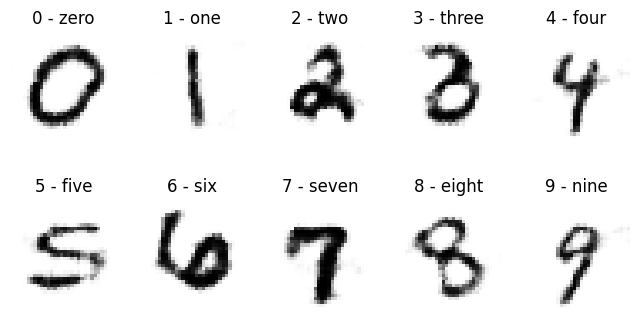

In [29]:
# Check for model existance
!cp /content/drive/MyDrive/Gans_models/cGANs_Gen_mnist /content
generator_path = '/content/cGANs_Gen_mnist'

run_gen_critic(generator=gen, generator_path=generator_path)

## **Main section**
Now it's time to check our generated images **Frechet Distance**, Since we use our model we cannot name it **Frechet Inception Distance** any more.

we going to use the Generator and Classifier we trained befor or even now.

In [50]:
class feartureEtraction(nn.Module):

    def __init__(self, modelpath):
        super().__init__()
        self.net = Classifier().to(device)
        self.net.load_state_dict(torch.load(modelpath))
        self.net.pool3.register_forward_hook(self._hook)

    def _hook(self, module, input, output):
        # N x 128 x 6 x 6
        self.output = output

    def forward(self, x): # Remember to normalize to [-1, 1]
        # Trigger output hook
        self.net(x)

        activations = self.output
        activations = F.adaptive_avg_pool2d(activations, (1,1)) # Output: N x 128 x 1 x 1
        return activations.view(x.shape[0], 128)

In [258]:
def main(generator, classifier_path, generator_path, data_with_label):
    feature_extractor = feartureEtraction(classifier_path).to(device)
    generator.load_state_dict(torch.load(generator_path))

    X, y = next(iter(train_loader))
    X, y = X.to(device), y.to(device)
    label = y.cpu().numpy()
    fake = generator(gen_noise(BS, Z_DIM), y).view(-1, C, H, W)


    fig = plt.figure(figsize=(15, 5))
    fig.text(0.4, 0.9, 'Generated images', fontstyle='oblique', fontsize=12, color='blue')
    fig.text(0.4, 0.4, 'Real images', fontstyle='oblique', fontsize=12, color='red')

    fig.text(0.12, 0.9, 'Frechet Distance for each number: ', fontsize=12, color='darkorchid')

    for i in range(10):
        n = np.where(label == i)[0]
        num = np.random.choice(n)

        real_img = feature_extractor(X[num, :, : ,:].unsqueeze(0)).view(-1, 1).cpu().detach()
        fake_img = feature_extractor(fake[num, :, : ,:].unsqueeze(0)).view(-1, 1).cpu().detach()

        mu1, sigma1 = torch.mean(real_img, dim=0).view(-1, 1), torch_cov(real_img, rowvar=False)
        mu2, sigma2 = torch.mean(fake_img, dim=0).view(-1, 1), torch_cov(fake_img, rowvar=False)
        frechet_distance = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)

        # num = torch.tensor([i], device=device)
        fig.add_subplot(2, 10, i+1)
        plt.imshow(fake[num, :, : ,:].detach().cpu().permute(1, 2, 0), cmap='gray_r')
        plt.title(f"{frechet_distance:.8f}", color='darkorchid')
        plt.axis(False)

        fig.add_subplot(2, 10, i+11)
        plt.imshow(X[num, :, : ,:].detach().cpu().permute(1, 2, 0), cmap='gray_r')
        # plt.title(f"{frechet_distance:.8f}")
        plt.axis(False)

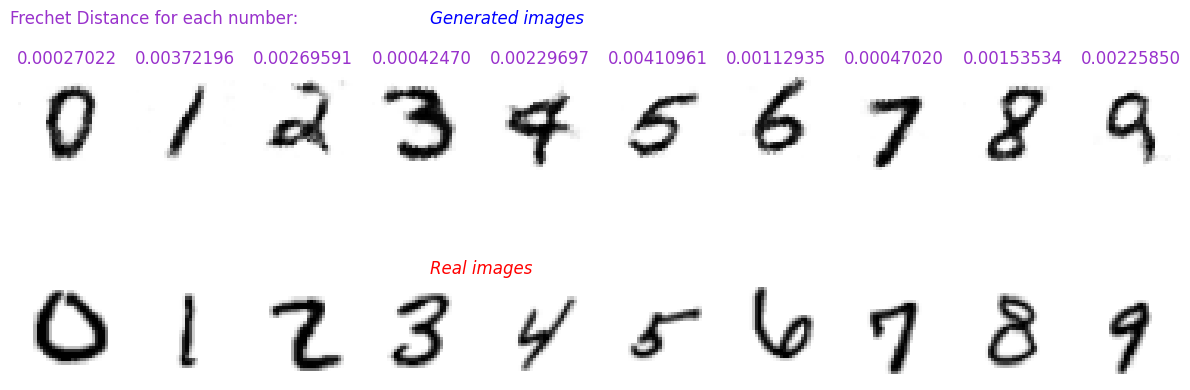

In [308]:
generator = Generator().to(device)
classifier_path = '/content/MNIST_Classifier_GAN_FID'
generator_path = '/content/cGANs_Gen_mnist'

main(generator, classifier_path, generator_path, train_loader)